In [ ]:
!pip install --upgrade cmdstanpy
!pip install git+https://github.com/OriolAbril/arviz.git@ci

from cmdstanpy import install_cmdstan
install_cmdstan()

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
!pip install mycolorpy

# **Data** **Generation**

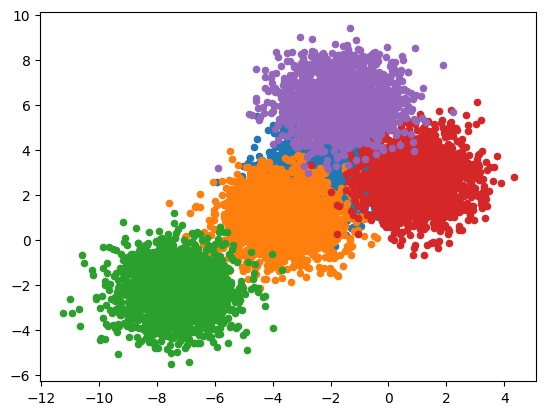

In [ ]:
from IPython.utils.sysinfo import num_cpus
seed = 2022
key = random.PRNGKey(seed)

# numero di cluster
K = 5

# dimensione del campione
d = 2

# numero di sample
N = 10000

# vectors of mean of clusters
sigma = 5
mu = random.normal(key,(K,d))*sigma

# cluster assignment
key = random.PRNGKey(2)
c = random.categorical(key,(1/K)*jnp.ones(shape=(K,)),axis=0,shape=(N,))
C = np.zeros(shape=(N,K))
for i in range(N):
  C[i,c[i]] = 1
C = jnp.array(C)

# Data
X = jnp.matmul(C,mu) + random.normal(key,(N,d))
import matplotlib.pyplot as plt

for i in range(K):
  plt.scatter(X[c==i,0], X[c==i,1], s = 20)
plt.show()

Implementation of MCMC in STAN(based on hamiltonian MC)

In [ ]:
gaussian_mix_uni = """
data {
  int N;
  int K;
  int d;
  matrix[N, d] y;
  vector[d] mu0;
  real <lower=0> sigma0;
}

parameters {
  matrix[K,d] means;
  simplex[K] weights;
}

transformed parameters {
}

model {

   //Likelihood
   vector[K] contributions;
   for (i in 1:N){
     for (k in 1:K){
      contributions[k] = log(weights[k]) + multi_normal_lpdf(y[i] | means[k], diag_matrix(rep_vector(1,d)));
      }
      target += log_sum_exp(contributions);
    }


   // Prior
   for(k in 1:K){
    means[k] ~ multi_normal(mu0, sigma0 * diag_matrix(rep_vector(1,d)));
   }
   weights ~ dirichlet(rep_vector(1,K));


}

generated quantities{
  matrix[N,K] phi;
  for(i in 1:N){
    vector[K] likelihoods;
    for(k in 1:K){
      likelihoods[k] = log(weights[k]) + multi_normal_lpdf(y[i] | means[k], diag_matrix(rep_vector(1,d)));
      }
    phi[i]=to_row_vector(softmax(likelihoods));
  }
}
"""

# Write stan model to file
stan_file = "./stan/gaussian_mix_uni.stan"
with open(stan_file, "w") as f:
    print(gaussian_mix_uni, file=f)

# Compile stan model
gaussian_mix_uni = CmdStanModel(stan_file=stan_file)

In [ ]:
# Input data
gmm_data = {
    "N": N,
    "K": K,
    "d": d,
    "y": X.tolist(),
    "mu0": np.full(d,0.0),
    "sigma0": sigma**2,
}

# Algorithm parameters
algo_params = {
    "n_chains": 1,
    "n_burnin": 1000,
    "n_iter": 2000,
}

# Sample
gmm_fit = gaussian_mix_uni.sample(data=gmm_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                  iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])
# Convert to arviz data type
chains = az.from_cmdstanpy(gmm_fit)

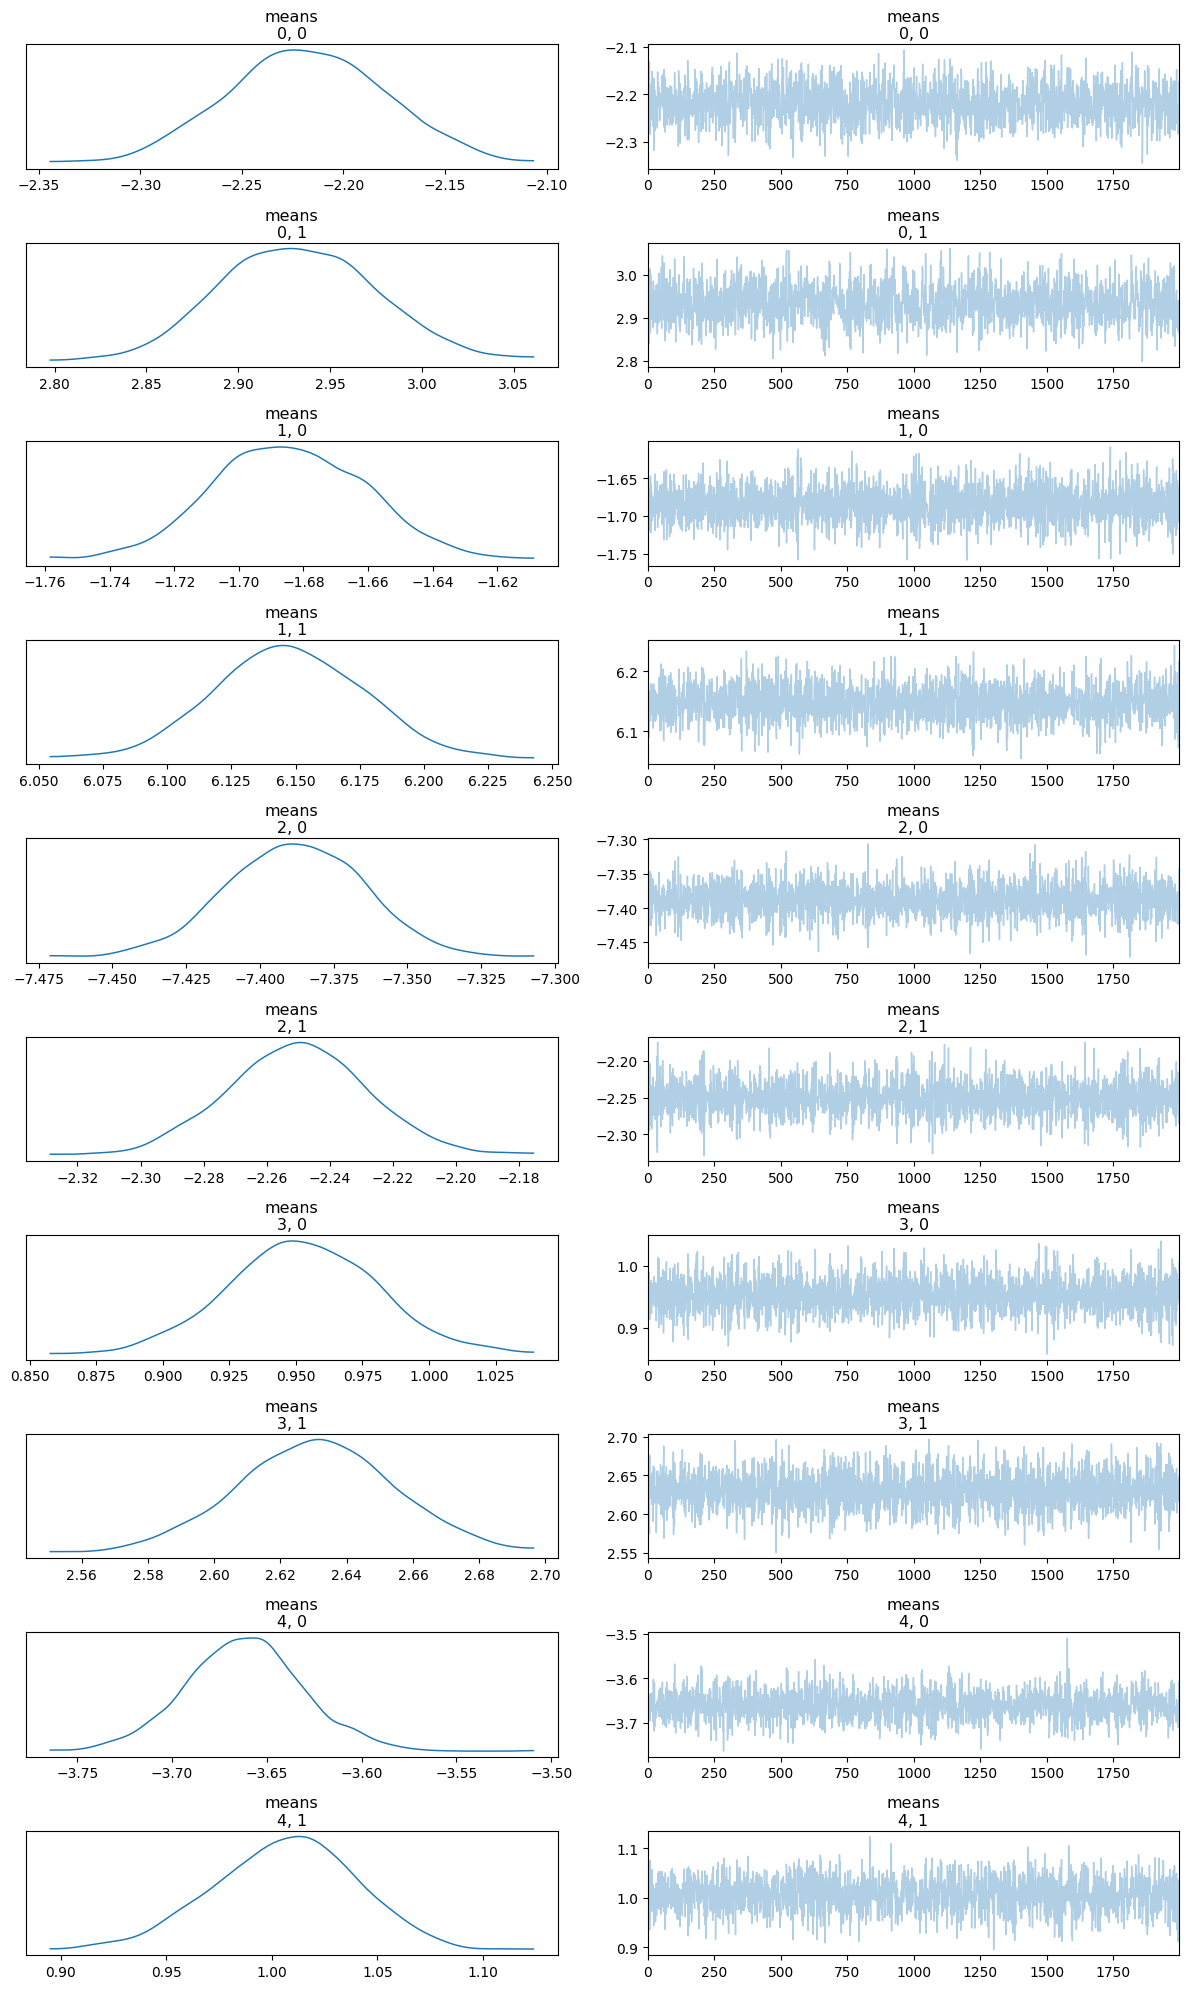

In [ ]:
az.plot_trace(chains, var_names=["means"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
gmm_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.33.1/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp8ngrdol3/stansummary-gaussian_mix_uni-wsa6k277.csv /tmp/tmp8ngrdol3/gaussian_mix_unip0w2r3zb/gaussian_mix_uni-20231122090641.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-4.215270e+04,9.338570e-02,2.639990e+00,-4.215760e+04,-4.215240e+04,-4.214920e+04,799.18,0.956469,1.004590
"means[1,1]",-2.218460e+00,9.028430e-04,3.834720e-02,-2.282360e+00,-2.218770e+00,-2.154320e+00,1804.02,2.159080,1.000870
"means[1,2]",2.932810e+00,1.093790e-03,4.273520e-02,2.865110e+00,2.931910e+00,3.004470e+00,1526.52,1.826960,0.999840
"means[2,1]",-1.684480e+00,3.650570e-04,2.361410e-02,-1.722330e+00,-1.685090e+00,-1.645490e+00,4184.28,5.007800,0.999682
"means[2,2]",6.147430e+00,5.643420e-04,2.879050e-02,6.101070e+00,6.147290e+00,6.194080e+00,2602.65,3.114880,0.999547
...,...,...,...,...,...,...,...,...,...
"phi[10000,1]",1.650260e-02,7.411810e-05,2.646030e-03,1.248670e-02,1.634490e-02,2.109170e-02,1274.50,1.525340,1.000720
"phi[10000,2]",5.973580e-09,2.354780e-11,1.132300e-09,4.327970e-09,5.880930e-09,7.977500e-09,2312.21,2.767290,0.999659
"phi[10000,3]",2.133810e-05,3.767630e-08,2.497150e-06,1.745060e-05,2.122050e-05,2.561310e-05,4392.90,5.257490,0.999620
"phi[10000,4]",7.217430e-06,1.763900e-08,1.017180e-06,5.645320e-06,7.151090e-06,8.931200e-06,3325.43,3.979920,1.000040


In [ ]:
weights = np.mean(gmm_fit.weights, axis = 0)
print(weights)

[0.19757257 0.19783906 0.197583   0.20158206 0.20542333]


In [ ]:
phi = np.mean(gmm_fit.phi, axis = 0)
print(phi[1:5,:])

[[5.09946057e-12 1.89009563e-23 9.99988458e-01 1.52857223e-19
  1.15383983e-05]
 [4.08827043e-04 1.54090073e-04 1.71407421e-26 9.99437059e-01
  1.72161303e-08]
 [1.73028413e-20 1.63391000e-34 1.00000000e+00 5.09978233e-31
  1.80288175e-11]
 [1.86970947e-01 7.09265907e-03 2.10803375e-18 8.05627526e-01
  3.08852400e-04]]


In [ ]:
means = np.mean(gmm_fit.means, axis = 0)
print(means)

[[-2.21846231  2.93281405]
 [-1.68448476  6.14742833]
 [-7.38800383 -2.2503122 ]
 [ 0.95257507  2.63053438]
 [-3.66200733  1.00629496]]


In [ ]:
fromchain = (np.array(gmm_fit.summary()['StdDev'][1:d*K+1]))**2
print(fromchain)

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.33.1/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp8ngrdol3/stansummary-gaussian_mix_uni-q4l9sf13.csv /tmp/tmp8ngrdol3/gaussian_mix_unip0w2r3zb/gaussian_mix_uni-20231122090641.csv
cwd: None


[0.00147051 0.0018263  0.00055763 0.00082889 0.00054213 0.0005094
 0.00076906 0.00055105 0.00094971 0.00111448]


In [ ]:
n_groups = len(fromchain)//d
temp = fromchain.reshape((n_groups, d))
variances = np.mean(temp, axis=1)
print(variances)

[0.0016484  0.00069326 0.00052577 0.00066005 0.0010321 ]


In [ ]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

def plot_clusters(data, phi, means):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = means.shape[0]

    # Create a list of colors for plotting
    #colors = plt.colormaps()
    colors=mcp.gen_color(cmap="winter",n=5)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    # Plot the cluster means
    for cluster in range(num_clusters):
        plt.scatter(means[cluster, 0], means[cluster, 1], marker='x', color='red', s=100, label=f'Mean Cluster {cluster}')

    plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

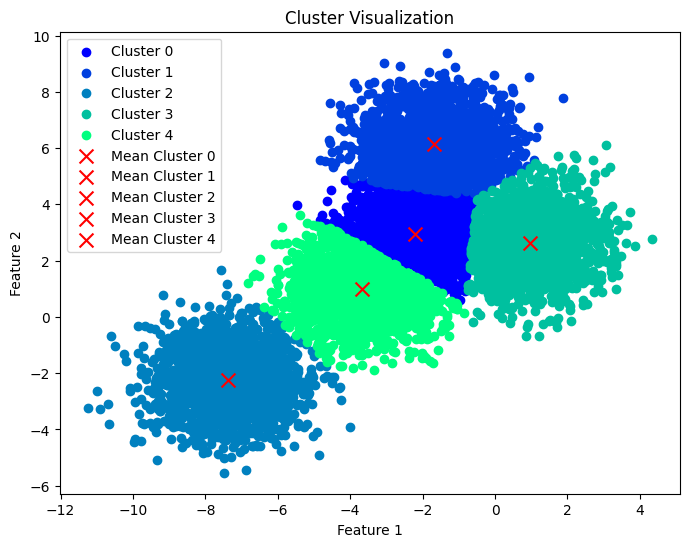

In [ ]:
plot_clusters(X, phi, means)

In [ ]:
from sklearn.metrics import adjusted_rand_score
from scipy.stats import multivariate_normal

def error_measure(m_real,s2_real,clus_real,m_pred,s2_pred,clus_pred):
  K=clus_pred.shape[1]
  N=clus_pred.shape[0]
  weights1=1/K*np.ones((K,))
  weights2=np.mean(clus_pred,axis=1)
  mix1=0
  mix2=0
  inter=0
  d=m_real.shape[1]

  for i in np.arange(K):
    for j in np.arange(K):
      s2_ij=s2_real[i]+s2_real[j]
      mix1+=weights1[i]*weights1[j]*multivariate_normal.pdf(m_real[i,],m_real[j,],s2_ij*np.eye(d))
      s2_ij=s2_pred[i]+s2_pred[j]
      mix2+=weights2[i]*weights2[j]*multivariate_normal.pdf(m_pred[i,],m_pred[j,],s2_ij*np.eye(d))
      s2_ij=s2_real[i]+s2_pred[j]
      inter+=weights1[i]*weights2[j]*multivariate_normal.pdf(m_real[i,],m_pred[j,],s2_ij*np.eye(d))

  error_m_s2=mix1+mix2-2*inter
  clus_real_num=np.empty((N,))
  clus_pred_num=np.empty((N,))
  for i in np.arange(N):
    clus_real_num[i]=np.argmax(clus_real[i,])
    clus_pred_num[i]=np.argmax(clus_pred[i,])

  error_clust=1-adjusted_rand_score(clus_real_num,clus_pred_num)
  return error_m_s2,error_clust

In [ ]:
n_cluster = np.sum(C, axis = 0)
m_post=1/(n_cluster.reshape((K,1))+1/sigma**2)*np.matmul(C.T,X)
s2_post=1/(n_cluster+1/sigma**2)

In [ ]:
error_m_s2,error_clust = error_measure(m_post,s2_post,C,means,variances,phi)
print(error_m_s2)
print(error_clust)

53.35659171341734
0.19724370647759215
